In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
from tensorflow import keras

tf.get_logger().setLevel('ERROR')

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
import random

seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)

tf.config.experimental.enable_op_determinism()

In [3]:
from HGQ import get_default_kq_conf, get_default_paq_conf
from HGQ import set_default_kq_conf, set_default_paq_conf
from HGQ import HDense, HQuantize
from HGQ.bops import trace_minmax, ResetMinMax, FreeBOPs
from HGQ import to_proxy_model

In [4]:
import HGQ
kq_conf = get_default_kq_conf()
paq_conf = get_default_paq_conf()

kq_conf['regularizer'] = None
paq_conf['regularizer'] = None

set_default_kq_conf(kq_conf)
set_default_paq_conf(paq_conf)

In [5]:
beta = 1e-3

# The first layer must be quantized, either by using HQuantize or Signature layers.
# Use only layers provided by HGQ. You can use functional API as well.
model = keras.Sequential([
    HQuantize(beta=beta, input_shape=(1,)),
    HDense(3, activation='relu', beta=beta),
    HDense(3, activation='relu', beta=beta),
    HDense(3, activation='relu', beta=beta),
    HDense(1, beta=beta),
])

In [6]:
opt = keras.optimizers.Adam(learning_rate = 0.002)
loss = keras.losses.MeanSquaredError()
model.compile(loss = loss, optimizer = opt)
callbacks = [ResetMinMax(), FreeBOPs()]

In [7]:
x = np.random.uniform(-3, 3, 100000).astype(np.float32)
y = x**2

In [8]:
model.fit(x, y, batch_size=128, epochs=10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
704/704 [==============================] - 6s 4ms/step - loss: 2.8872 - val_loss: 0.4973 - bops: 267.0000
Epoch 2/10
704/704 [==============================] - 1s 2ms/step - loss: 0.4481 - val_loss: 0.3656 - bops: 230.0000
Epoch 3/10
704/704 [==============================] - 1s 2ms/step - loss: 0.3652 - val_loss: 0.3069 - bops: 217.0000
Epoch 4/10
704/704 [==============================] - 1s 2ms/step - loss: 0.3188 - val_loss: 0.3231 - bops: 202.0000
Epoch 5/10
704/704 [==============================] - 1s 2ms/step - loss: 0.2870 - val_loss: 0.2341 - bops: 191.0000
Epoch 6/10
704/704 [==============================] - 2s 2ms/step - loss: 0.2801 - val_loss: 0.2355 - bops: 174.0000
Epoch 7/10
704/704 [==============================] - 1s 2ms/step - loss: 0.2800 - val_loss: 0.2449 - bops: 180.0000
Epoch 8/10
704/704 [==============================] - 1s 2ms/step - loss: 0.2718 - val_loss: 0.2807 - bops: 186.0000
Epoch 9/10
704/704 [==============================] - 1s 2ms/ste

In [9]:
x0 = np.linspace(-3,3,2000).astype(np.float32)
yp = model.predict(x0, batch_size=1000, verbose=0) # type: ignore

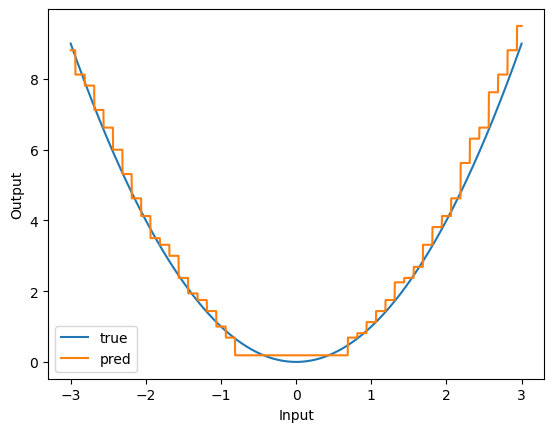

In [10]:
plt.axes(xlabel='Input', ylabel='Output')
plt.plot(x0, x0**2, label='true')
plt.plot(x0, yp, label='pred')
plt.legend()
plt.show()

In [11]:
# This is necessary before converting the model to a proxy model.
# It also determines the full bitwidth (integer part) necessary for conversion.
trace_minmax(model, x0, bsz=1000)

h_quantize: 0.0
h_dense: 48.0
h_dense_1: 42.0
h_dense_2: 36.0
h_dense_3: 26.0


152.0

In [12]:
# Intermediate model for hls4ml conversion.
# This is also a bit-accurate emulator of the hls4ml converted model up to float precision.
proxy = to_proxy_model(model)

In [13]:
from hls4ml.converters import convert_from_keras_model

# Use the proxy model here!
model_hls = convert_from_keras_model(
    proxy,
    'hls4ml_prj',
    part='xcvu9p-flga2104-2L-e',
    clock_period=5,
)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: h_quantize, layer type: FixedPointQuantizer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: h_dense, layer type: Dense, input shapes: [[None, 1]], output shape: [None, 3]
Layer name: h_dense_quantizer, layer type: FixedPointQuantizer, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: re_lu, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_relu_quantizer, layer type: FixedPointQuantizer, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_1, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_1_quantizer, layer type: FixedPointQuantizer, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: re_lu_1, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_1_relu_quantizer, lay

In [14]:
# Notice that the tarball file generated by hls4ml should NOT be used when using HGQ, as it is not patched.
model_hls.compile()

Writing HLS project
Done


/home/calad/micromamba/envs/HGQ/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
hls_p = model_hls.predict(x0).ravel()
keras_p = model.predict(x0, batch_size=1000, verbose=0).ravel() # type: ignore

In [16]:
np.all(hls_p==keras_p) # bit-accurate

True

In [17]:
# As HGQ aims for minimal latency, all fixed point values have ovverflow mode WRAP by default.
# Though not recommended in most cases, you may disable this behavior by setting aggressive=False in to_proxy_model.
# Instead, you could set cover_factor in trace_minmax to a higher value to prevent overflow statistically.

# Now let's create a model that overflows
# As bitwidths decreases in general, total ebops also decreases.
ebops =trace_minmax(model, x0, bsz=1000, cover_factor=0.5) # Cover factor<1.9 will overflow in general.
print(f'ebops: {ebops}')
proxy_overflow = to_proxy_model(model)

/home/calad/repo/FHQ/src/HGQ/bops/bops.py:64: UserWarning: cover_factor<1.0 will likely to result in overflows.
  warn(f'cover_factor<1.0 will likely to result in overflows.')


h_quantize: 0.0
h_dense: 40.0
h_dense_1: 32.0
h_dense_2: 30.0
h_dense_3: 24.0
ebops: 126.0


In [18]:
model_hls_overflow = convert_from_keras_model(
    proxy_overflow,
    'hls4ml_prj',
    part='xcvu9p-flga2104-2L-e',
    clock_period=5,
)

Interpreting Model
Topology:
Layer name: input_6, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: h_quantize, layer type: FixedPointQuantizer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: h_dense, layer type: Dense, input shapes: [[None, 1]], output shape: [None, 3]
Layer name: h_dense_quantizer, layer type: FixedPointQuantizer, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: re_lu_3, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_relu_quantizer, layer type: FixedPointQuantizer, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_1, layer type: Dense, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_1_quantizer, layer type: FixedPointQuantizer, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: re_lu_4, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
Layer name: h_dense_1_relu_quantizer, l

In [19]:
model_hls_overflow.compile()

Writing HLS project
Done


In [20]:
hls_p_overflow = model_hls_overflow.predict(x0).ravel()
keras_p_overflow = model.predict(x0, batch_size=1000, verbose=0).ravel() # type: ignore
proxy_p_overflow = proxy_overflow.predict(x0, batch_size=1000, verbose=0).ravel() # type: ignore

In [21]:
np.mean(hls_p_overflow==keras_p_overflow) # overflows!

0.5835

In [22]:
np.all(hls_p_overflow==proxy_p_overflow) # bit-accurate

True